In [1]:
from PIL import Image
from scipy import ndimage

import matplotlib.pyplot as plt
import numpy as np
import os
import json
import cv2

import skimage as sk
import scipy as sc
from skimage.feature import corner_harris, peak_local_max
from skimage.transform import resize
from matplotlib import colors as mcolors

# Project 3a

In [2]:
def read_image(path):
    img = Image.open(path)
    out = np.asarray(img, dtype=np.float64)
    out = out / out.max()
    return out

## Part 1: Shoot the Pictures

In [3]:
set1 = "../../img/pano_3"
set2 = "../../img/pano_4"

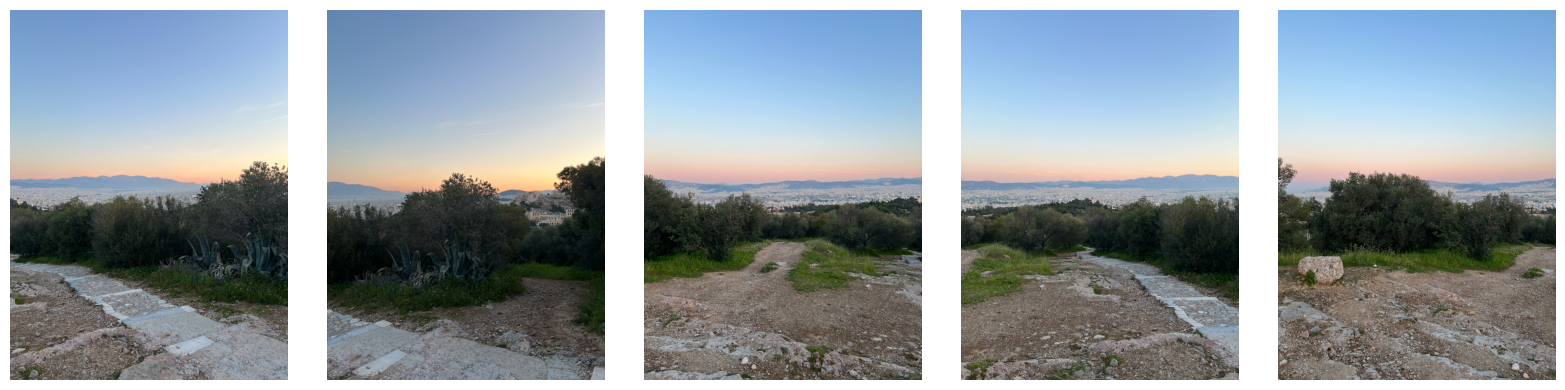

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4))

for i, f in enumerate(os.listdir(set1)):
    axes[i].imshow(read_image(os.path.join(set1, f)))
    axes[i].axis("off")

plt.tight_layout()
plt.show()

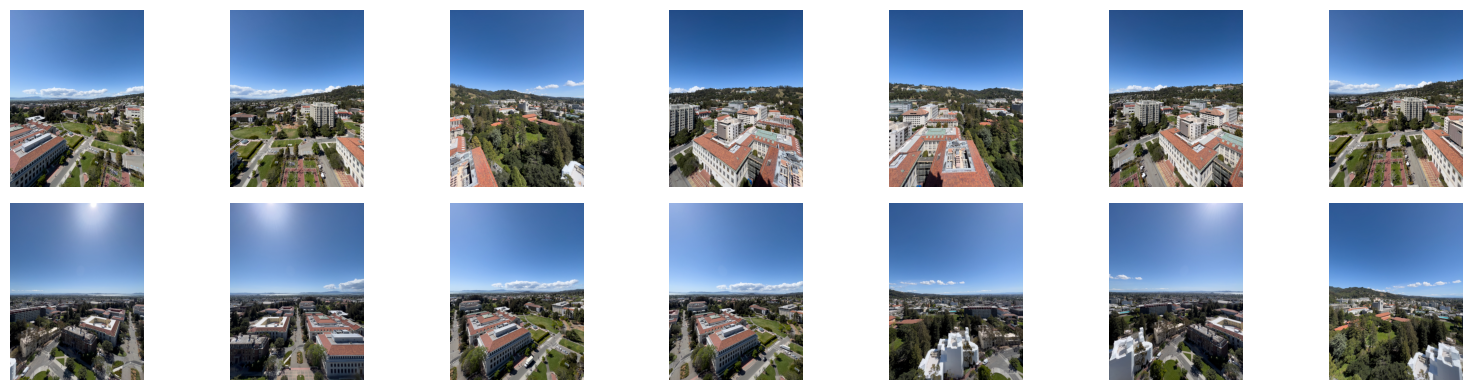

In [5]:
fig, axes = plt.subplots(2, 7, figsize=(16, 4))

for i, f in enumerate(os.listdir(set2)):
    axes[i // 7][i % 7].imshow(read_image(os.path.join(set2, f)))
    axes[i // 7][i % 7].axis("off")

plt.tight_layout()
plt.show()

## Part 2: Recover Homographies

In [6]:
def computeH(p1, p2):
    im1_pts = np.asarray(p1, dtype=np.float64)
    im2_pts = np.asarray(p2, dtype=np.float64)
    N = im1_pts.shape[0]

    # Aw = b
    A = np.zeros((2 * N, 8), dtype=np.float64)
    b = np.zeros((2 * N,), dtype=np.float64)

    for i, ((x, y), (xp, yp)) in enumerate(zip(im1_pts, im2_pts)):
        # xp = h11*x + h12*y + h13 - h31*x*xp - h32*y*xp - 1*xp
        # yp = h21*x + h22*y + h23 - h31*x*yp - h32*y*yp - 1*yp
        
        A[2*i, 0:3] = [x, y, 1]
        A[2*i, 6:8] = [-x * xp, -y * xp]
        b[2*i] = xp

        A[2*i+1, 3:6] = [x, y, 1]
        A[2*i+1, 6:8] = [-x * yp, -y * yp]
        b[2*i+1] = yp

    w, *_ = np.linalg.lstsq(A, b)
    H = np.reshape(np.append(w, 1), (3, 3))

    return H

In [7]:
correspondence = json.load(open("correspondences/2_3.json", "r"))
im1_pts = np.array(correspondence["im1Points"])[:, ::-1]
im2_pts = np.array(correspondence["im2Points"])[:, ::-1]

H = computeH(im1_pts, im2_pts)
print(H)

[[ 1.23908710e+00  3.70198604e-01 -1.45917469e+02]
 [-1.51962921e-01  1.49890322e+00 -5.10552730e+02]
 [-1.56443141e-04  7.58403119e-04  1.00000000e+00]]


## Part 3: Warp the Images

In [8]:
def interpolate(method, img, pts):
    x, y = pts.transpose(-1, *range(pts.ndim - 1))
    h, w = img.shape[:2]
    C = 1 if img.ndim == 2 else img.shape[2]
    
    if method in (0, "nn"):
        xr, yr = np.rint(x).astype(int), np.rint(y).astype(int)

        mask = (xr >= 0) & (xr < h) & (yr >= 0) & (yr < w)
        
        out = np.zeros((x.size, C), dtype=float)
        out[mask] = (img if C > 1 else img[..., None])[xr[mask], yr[mask]]
        
        return out
        # return img[xr, yr]
        
    elif method in (1, "bil"):
        # x_floor, x_ceil, y_floor, y_ceil
        xf, yf = np.floor(x).astype(int), np.floor(y).astype(int)
        xc, yc = xf + 1, yf + 1

        mask = (xf >= 0) & (xc < h) & (yf >= 0) & (yc < w)
        
        t, r, b, l = x-xf, yc-y, xc-x, y-yf # top, right, bottom, left distances
        tr, tl, bl, br = l*b, b*r, r*t, t*l # top right, top left, bottom left, bottom right weights

        out = np.zeros((x.size, C), dtype=float)
        out[mask] = (
            img[xf[mask], yf[mask]] * tl[mask][..., None] +
            img[xf[mask], yc[mask]] * tr[mask][..., None] +
            img[xc[mask], yf[mask]] * bl[mask][..., None] + 
            img[xc[mask], yc[mask]] * br[mask][..., None]
        )

        return out
        # return (img[xf, yf] * tl[..., None] + img[xf, yc] * tr[..., None] + img[xc, yf] * bl[..., None] + img[xc, yc] * br[..., None])

def warp(method, img, H):
    h, w = img.shape[:2]
    C = 1 if img.ndim == 2 else img.shape[2]
    
    corners = np.array([[0, 0, h, h],
                        [0, w, w, 0],
                        [1, 1, 1, 1]], dtype=float)
    warped = H @ corners
    warped = (warped[:2] / warped[2]).T

    xy_min, xy_max = np.min(warped, axis=0), np.max(warped, axis=0)

    # make output grid
    offset = np.floor(xy_min).astype(int)
    out_hw = (np.floor(xy_max).astype(int) - offset + 1)
    out_h, out_w = int(out_hw[0]), int(out_hw[1])

    rr, cc = np.mgrid[0:out_h, 0:out_w]
    rr_abs, cc_abs = rr + offset[0], cc + offset[1]

    # inverse warping
    H_inv = np.linalg.inv(H)
    target = np.vstack([rr_abs.ravel(), cc_abs.ravel(), np.ones(rr_abs.size, dtype=float)])
    source = H_inv @ target
    source = (source[:2] / source[2]).T

    # interpolate
    out = np.zeros((out_h, out_w, C), dtype=float)
    interpolated = interpolate(method, img if C > 1 else img[..., None], source)
    out.reshape(-1, C)[:] = interpolated

    if img.ndim == 2:
        out = out[..., 0]

    return np.clip(out, 0, 1), offset

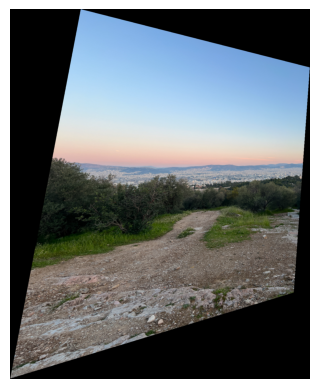

In [9]:
img = read_image("../../img/pano_3/2.jpg")
warped = warp(1, img, H)[0]

plt.axis("off")
plt.imshow(warped)
plt.show()

In [10]:
# rectification

img_stadium = read_image("../../img/stadium.jpg")
img_building = read_image("../../img/building.jpg")

# calculated in photoshop
coords_stadium = np.array([[109, 642], [136, 394], [510, 395], [505, 688]])
coords_building = np.array([[790, 291], [803, 232], [969, 230], [957, 291]])

target_stadium = np.array([[109, 693], [109, 394], [535, 394], [535, 693]])
target_building = np.array([[797, 291], [797, 231], [963, 231], [963, 291]])

H_stadium = computeH(coords_stadium, target_stadium)
H_building = computeH(coords_building, target_building)

In [11]:
def plot_cycle(ax, points: np.ndarray, **kwargs):
    cycled_points = np.vstack([points, points[:1]])
    ax.plot(*cycled_points.T, **kwargs)

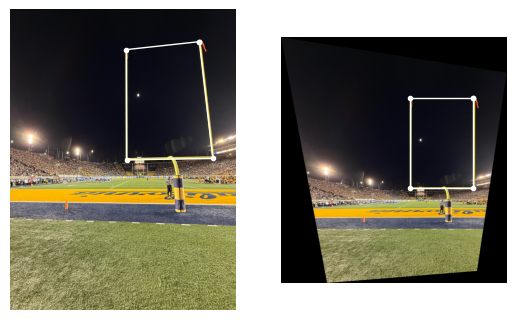

In [12]:
fig, axs = plt.subplots(1, 2)
axs[0].axis("off")
axs[0].imshow(img_stadium)
plot_cycle(axs[0], coords_stadium[:, ::-1], linewidth=1, marker='.', color='white')

rectified_im0, offset_im0 = warp(1, img_stadium, H_stadium)
axs[1].axis("off")
axs[1].imshow(rectified_im0)
plot_cycle(axs[1], (target_stadium - offset_im0)[:, ::-1], linewidth=1, marker='.', color='white')
plt.show()

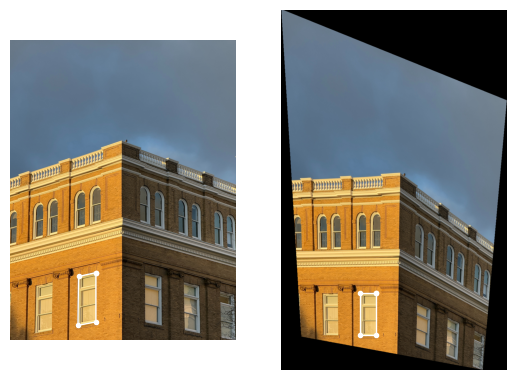

In [13]:
fig, axs = plt.subplots(1, 2)
axs[0].axis("off")
axs[0].imshow(img_building)
plot_cycle(axs[0], coords_building[:, ::-1], linewidth=1, marker='.', color='white')

rectified_im1, offset_im1 = warp(1, img_building, H_building)
axs[1].axis("off")
axs[1].imshow(rectified_im1)
plot_cycle(axs[1], (target_building - offset_im1)[:, ::-1], linewidth=1, marker='.', color='white')
plt.show()

## Part 4: Image Mosiac

In [14]:
def gaussian_stack(img, depth=4, sigma=1.6):
    img = np.asarray(img, dtype=np.float32)
    if img.ndim == 2:
        img = img[..., None]
    g = [img]
    for i in range(depth):
        g_blur = cv2.GaussianBlur(g[-1], (0, 0), sigmaX=sigma, borderType=cv2.BORDER_REFLECT_101)
        h, w = g_blur.shape[:2]
        small = cv2.resize(g_blur, (w // 2, h // 2), interpolation=cv2.INTER_AREA)
        if small.ndim == 2:
            small = small[..., None]
        g.append(small)
    return g

def laplacian_stack(img, depth=4, sigma=1.6):
    g, l = gaussian_stack(img, depth, sigma), []
    for i in range(depth):
        h, w = g[i].shape[:2]
        g_next = cv2.resize(g[i + 1], (w, h), interpolation=cv2.INTER_LINEAR)
        l.append(g[i] - g_next)
    l.append(g[-1])
    return l

def collapse_blend(l):
    out = l[-1]
    for i in range(len(l) - 2, -1, -1):
        h, w = l[i].shape[:2]
        l_next = cv2.resize(out, (w, h), interpolation=cv2.INTER_LINEAR)
        out = l_next + l[i]
    return out

In [15]:
def buffer_images(imgs, offsets):
    offsets = np.asarray(offsets, dtype=int)
    sizes = np.array([img.shape[:2] for img in imgs], dtype=int)
    mins, maxes = offsets, offsets + sizes

    tl = mins.min(axis=0)
    br = maxes.max(axis=0)
    h_out, w_out = (br - tl).tolist()

    C = imgs[0].shape[-1]
    out = np.zeros((len(imgs), h_out, w_out, C), dtype=np.float32)

    for i, img in enumerate(imgs):
        y0, x0 = (offsets[i] - tl).tolist()
        h, w = sizes[i].tolist()
        out[i, y0:y0+h, x0:x0+w, :] = img

    return out

def blending_weights(imgs):
    img = np.asarray(imgs, dtype=np.float32)
    dists = []

    # dist to border per img
    for img in imgs:
        valid = (img > 0).any(axis=2).astype(np.uint8)
        dists.append(ndimage.distance_transform_edt(valid).astype(np.float32))
    
    d = np.stack(dists, axis=0)+ 1e-12
    w = d / d.sum(axis=0, keepdims=True)
    
    return w[..., None]

def blend(imgs, depth=4, sigma=1.6):
    imgs = np.asarray(imgs, dtype=np.float32)
    N = imgs.shape[0]
    wp = [gaussian_stack(blending_weights(imgs)[i], depth, sigma) for i in range(N)] # weight pyramids
    lp = [laplacian_stack(imgs[i], depth, sigma) for i in range(N)] # laplacian pyramids

    # all levels
    blended_levels = []
    for level in range(depth):
        wl = np.stack([wp[i][level] for i in range(N)], axis=0) # weight at single level for imgs
        ll = np.stack([lp[i][level] for i in range(N)], axis=0) # laplacians at same level for imgs
        blended_levels.append(np.sum(wl * ll, axis=0)) # weights * laplacian

    # add back coarsest gaussian
    wl = np.stack([wp[i][-1] for i in range(N)], axis=0)
    gl = np.stack([lp[i][-1] for i in range(N)], axis=0)
    blended_levels.append(np.sum(wl * gl, axis=0))

    return np.clip(collapse_blend(blended_levels), 0, 1)

In [16]:
def mosiac(imgs, correspondence):
    pts = [np.array(correspondence[key])[:, ::-1] for key in ["im1Points", "im2Points"]]
    H = computeH(pts[0], pts[1])

    warped1, offset1 = warp(1, imgs[0], H)
    warped2, offset2 = warp(1, imgs[1], np.eye(3))

    buf = buffer_images([warped1, warped2], [offset1, offset2]).astype(np.float32)
    return blend(buf)

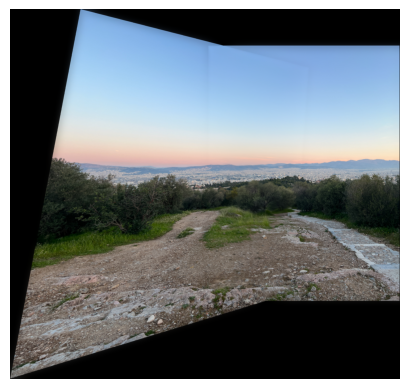

In [17]:
img1 = read_image("../../img/pano_3/2.jpg").astype(np.float32)
img2 = read_image("../../img/pano_3/3.jpg").astype(np.float32)
correspondence = json.load(open("correspondences/2_3.json", "r"))

result = mosiac([img1, img2], correspondence)
plt.axis("off"); plt.imshow(np.clip(result, 0, 1)); plt.show()

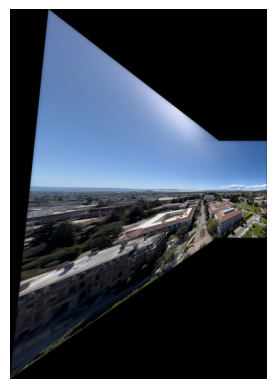

In [18]:
img1 = read_image("../../img/pano_4/5.jpg").astype(np.float32)
img2 = read_image("../../img/pano_4/6.jpg").astype(np.float32)
correspondence = json.load(open("correspondences/5_6.json", "r"))

result = mosiac([img1, img2], correspondence)
plt.axis("off"); plt.imshow(np.clip(result, 0, 1)); plt.show()

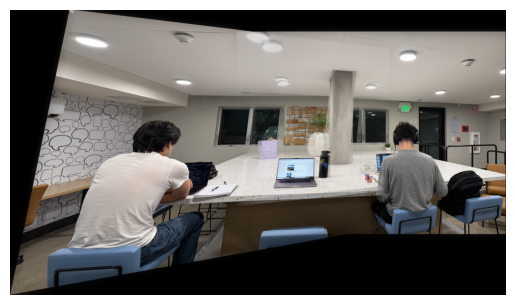

In [19]:
img1 = read_image("../../img/pano_5/1.jpg").astype(np.float32)
img2 = read_image("../../img/pano_5/2.jpg").astype(np.float32)
correspondence = json.load(open("correspondences/1_2.json", "r"))

result = mosiac([img1, img2], correspondence)
plt.axis("off"); plt.imshow(np.clip(result, 0, 1)); plt.show()

# Project 3b

## Part 1: Harris Corner Detection

In [20]:
# harris.py sample code

import numpy as np
from skimage.feature import corner_harris, peak_local_max


def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=1)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords


def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """

    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert dimx == dimc, 'Data dimension does not match dimension of centers'

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)

In [21]:
def anms(coords_2xN, h, max_pts=500, c_robust=0.9):
    if coords_2xN.size == 0:
        return coords_2xN

    ys, xs = coords_2xN
    strengths = h[ys, xs]

    # sort by strength
    order = np.argsort(-strengths)
    ys_s, xs_s = ys[order], xs[order]
    strengths_s = strengths[order]
    N = ys_s.size

    P = np.column_stack([xs_s.astype(float), ys_s.astype(float)])
    D2 = dist2(P, P)
    np.fill_diagonal(D2, np.inf)

    radii = np.full(N, np.inf, dtype=float)
    for i in range(1, N):
        r_i = np.min(D2[i, :i])
        radii[i] = np.sqrt(r_i)

    # keep top by radius
    keep_idx = np.argsort(-radii)[:min(max_pts, N)]
    return np.vstack([ys_s[keep_idx], xs_s[keep_idx]])

def harris_corners(im, edge_discard=20, max_pts=500, c_robust=0.9):
    h, coords = get_harris_corners(im, edge_discard=edge_discard)
    coords_sel = anms(coords, h, max_pts=max_pts, c_robust=c_robust)
    return h, coords_sel

In [22]:
def gray(im):
    im = np.asarray(im)

    # grayscale
    if im.ndim == 2:
        g = im

    # RGBA
    elif im.ndim == 3 and im.shape[2] == 4:
        g = sk.color.rgb2gray(sk.color.rgba2rgb(im))

    # RGB
    elif im.ndim == 3 and im.shape[2] == 3:
        g = sk.color.rgb2gray(im)
    
    else:
        raise ValueError(f"Unexpected image shape {im.shape}")

    return sk.util.img_as_float32(g)

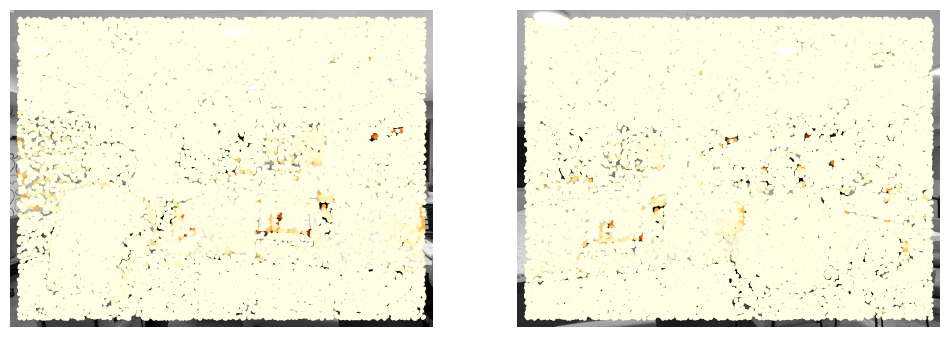

In [23]:
# without anms

im1 = read_image("../../img/pano_5/1.jpg").astype(np.float32)
im2 = read_image("../../img/pano_5/2.jpg").astype(np.float32)

gray_im1 = gray(im1)
gray_im2 = gray(im2)

im1h, im1interest_points = get_harris_corners(gray_im1)
im2h, im2interest_points = get_harris_corners(gray_im2)

ys1, xs1 = im1interest_points
ys2, xs2 = im2interest_points

plt.rcParams["figure.figsize"] = (12.0, 16.0)
fig, axs = plt.subplots(1, 2)

axs[0].axis("off")
axs[0].imshow(gray_im1, cmap="gray")
axs[0].scatter(xs1, ys1, s=5, c=im1h[ys1, xs1], cmap="YlOrBr")

axs[1].axis("off")
axs[1].imshow(gray_im2, cmap="gray")
axs[1].scatter(xs2, ys2, s=5, c=im2h[ys2, xs2], cmap="YlOrBr")

plt.show()

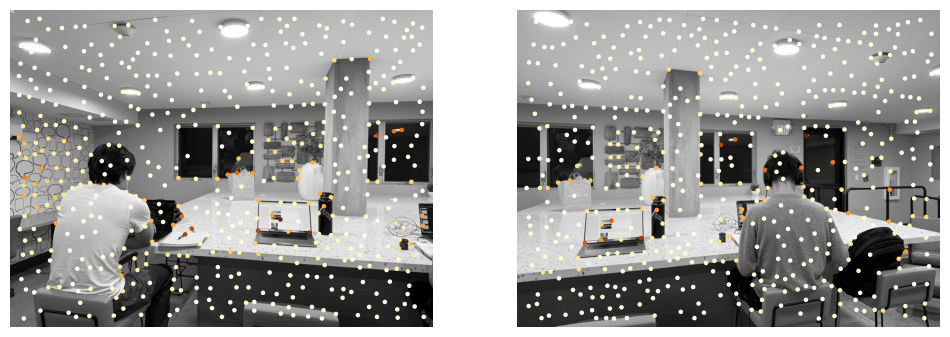

In [24]:
# with anms

im1 = read_image("../../img/pano_5/1.jpg").astype(np.float32)
im2 = read_image("../../img/pano_5/2.jpg").astype(np.float32)

gray_im1 = gray(im1)
gray_im2 = gray(im2)

im1h, im1interest_points = harris_corners(gray_im1)
im2h, im2interest_points = harris_corners(gray_im2)

ys1, xs1 = im1interest_points
ys2, xs2 = im2interest_points

plt.rcParams["figure.figsize"] = (12.0, 16.0)
fig, axs = plt.subplots(1, 2)

axs[0].axis("off")
axs[0].imshow(gray_im1, cmap="gray")
axs[0].scatter(xs1, ys1, s=5, c=im1h[ys1, xs1], cmap="YlOrBr")

axs[1].axis("off")
axs[1].imshow(gray_im2, cmap="gray")
axs[1].scatter(xs2, ys2, s=5, c=im2h[ys2, xs2], cmap="YlOrBr")

plt.show()

## Part 2: Feature Descriptor Extraction

In [25]:
def feature_descriptors(im, interest_points, s=8, d=5):
    ksize = 1 + s * d
    half = ksize // 2
    descs = []

    # make sure shape (N, 2) = (y, x)
    pts = interest_points if (interest_points.ndim == 2 and interest_points.shape[1] == 2) else interest_points.T

    for y, x in pts:
        patch = im[int(y - half):int(y + half + 1), int(x - half):int(x + half + 1)]
        if patch.shape[0] != ksize or patch.shape[1] != ksize:
            continue
        small = resize(patch, (s, s), anti_aliasing=False)
        small = (small - np.mean(small)) / np.std(small)
        descs.append(small)

    return np.array(descs)

def image_patches(im, interest_points, ksize=40):
    half = ksize // 2
    patches = []

    # make sure shape (N, 2) = (y, x)
    pts = interest_points if (interest_points.ndim == 2 and interest_points.shape[1] == 2) else interest_points.T

    for y, x in pts:
        patch = im[int(y - half):int(y + half + 1), int(x - half):int(x + half + 1)]
        if patch.shape[0] != ksize or patch.shape[1] != ksize:
            continue
        patches.append(patch)

    return np.array(patches)

In [26]:
im1fds = feature_descriptors(gray_im1, im1interest_points)
im2fds = feature_descriptors(gray_im2, im2interest_points)

im1patches = image_patches(im1, im1interest_points)
im2patches = image_patches(im2, im2interest_points)

## Part 3: Feature Matching

In [27]:
def feature_match(im1fds, im2fds):
    f1 = im1fds.reshape(im1fds.shape[0], -1)
    f2 = im2fds.reshape(im2fds.shape[0], -1)

    M = sc.spatial.distance_matrix(f1, f2)

    order = np.argsort(M, axis=1)
    best = order[:, 0]
    second = order[:, 1]

    d1 = M[np.arange(M.shape[0]), best]
    d2 = M[np.arange(M.shape[0]), second]

    threshold = 0.7
    mask = d1 < threshold * d2

    return np.stack([np.nonzero(mask)[0], best[mask]], axis=1)

In [28]:
pair_indices = feature_match(im1fds, im2fds)

im1_pts = im1interest_points if (im1interest_points.ndim == 2 and im1interest_points.shape[1] == 2) else im1interest_points.T
im2_pts = im2interest_points if (im2interest_points.ndim == 2 and im2interest_points.shape[1] == 2) else im2interest_points.T

im1feature_points = im1_pts[pair_indices[:, 0]]
im2feature_points = im2_pts[pair_indices[:, 1]]

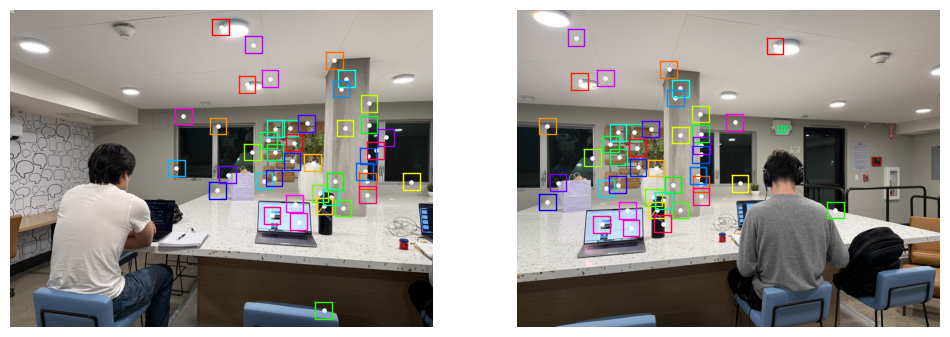

In [29]:
def color(i, scale=1):
    h = (i % scale) / float(scale)
    return mcolors.hsv_to_rgb((h, 1.0, 1.0))

def plot_cycle(ax, points, color="white"):
    xs = np.r_[points[:, 0], points[0, 0]]
    ys = np.r_[points[:, 1], points[0, 1]]
    ax.plot(xs, ys, color=color, linewidth=1)

plt.rcParams["figure.figsize"] = (12.0, 16.0)
fig, axs = plt.subplots(1, 2)

axs[0].axis("off")
axs[0].imshow(im1)
axs[0].scatter(im1feature_points[:, 1], im1feature_points[:, 0], s=5, color="white")

axs[1].axis("off")
axs[1].imshow(im2)
axs[1].scatter(im2feature_points[:, 1], im2feature_points[:, 0], s=5, color="white")

box = np.array([[-20, -20], [20, -20], [20, 20], [-20, 20]])
for n, (im1fp, im2fp) in enumerate(zip(im1feature_points, im2feature_points)):
    plot_cycle(axs[0], im1fp[::-1] + box, color=color(n, scale=len(pair_indices)))
    plot_cycle(axs[1], im2fp[::-1] + box, color=color(n, scale=len(pair_indices)))

plt.show()

Feature pair 0


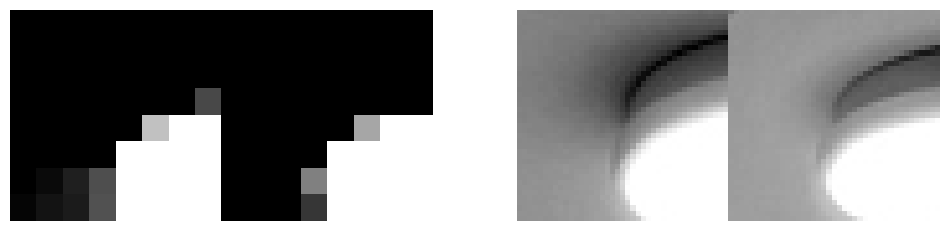

Feature pair 1


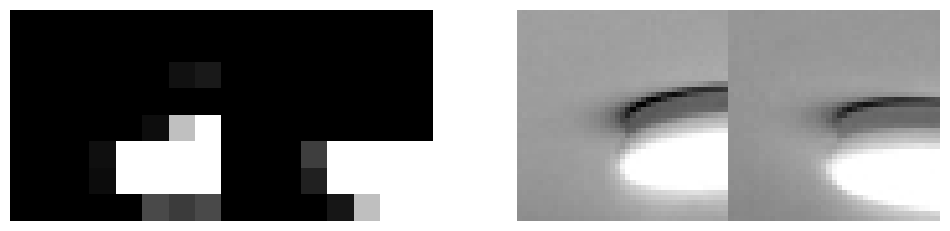

Feature pair 2


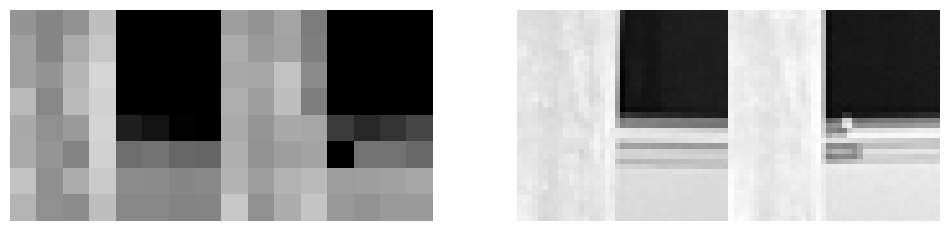

Feature pair 3


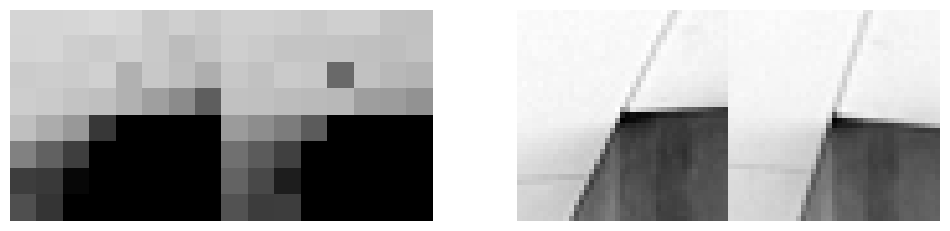

Feature pair 4


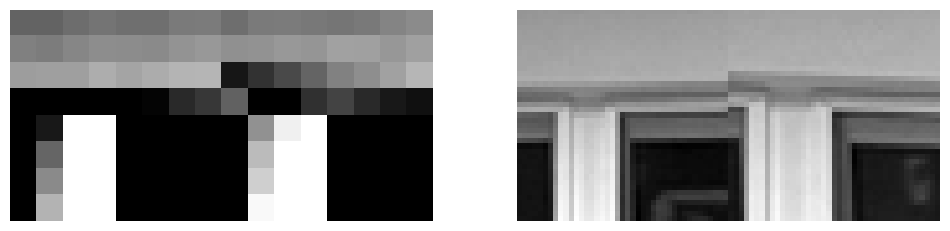

Feature pair 5


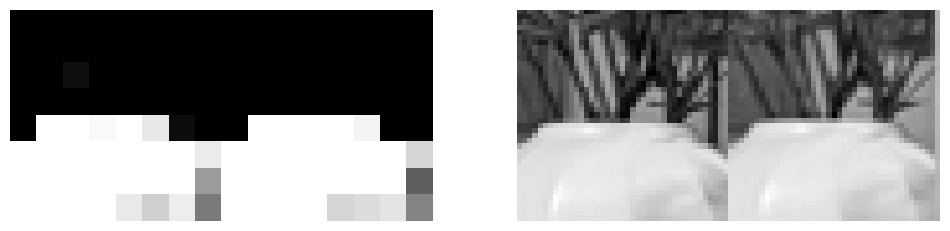

Feature pair 6


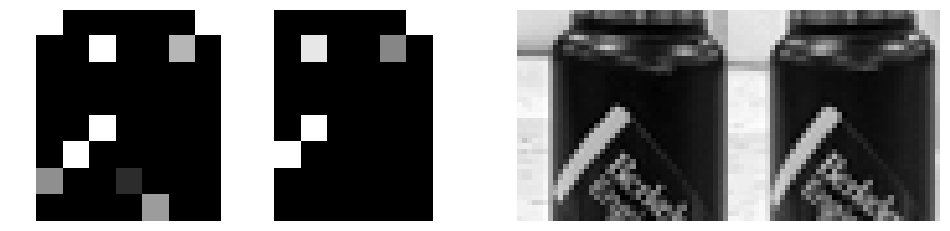

Feature pair 7


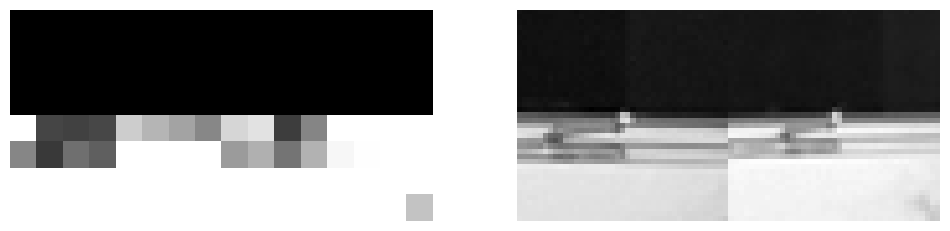

Feature pair 8


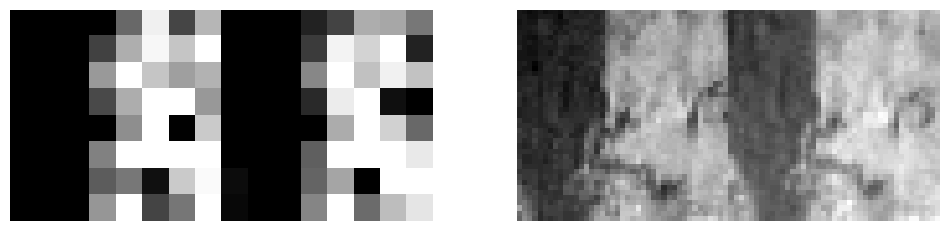

Feature pair 9


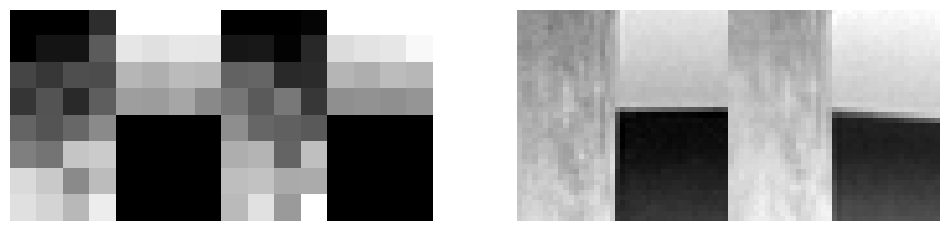

Feature pair 10


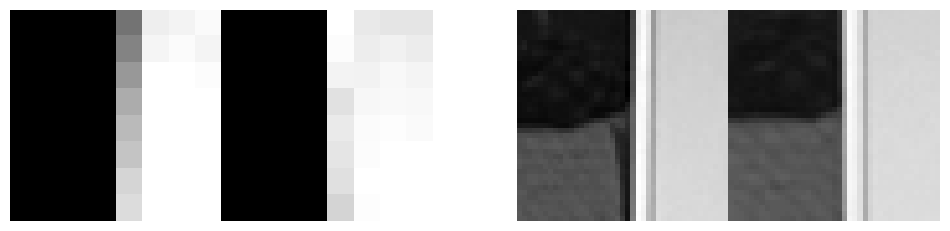

Feature pair 11


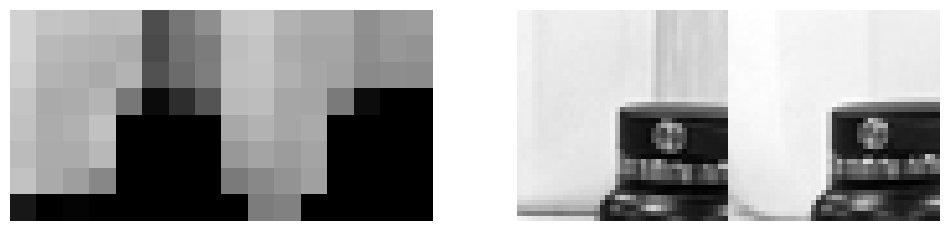

Feature pair 12


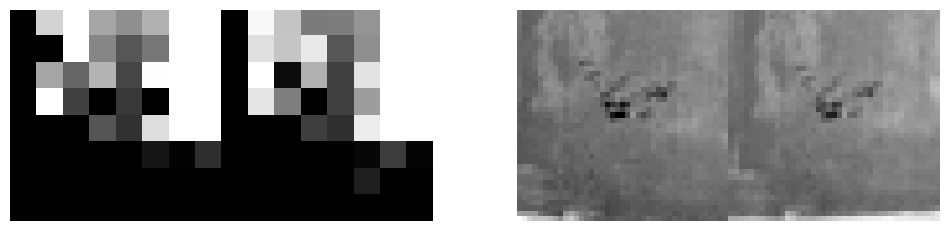

Feature pair 13


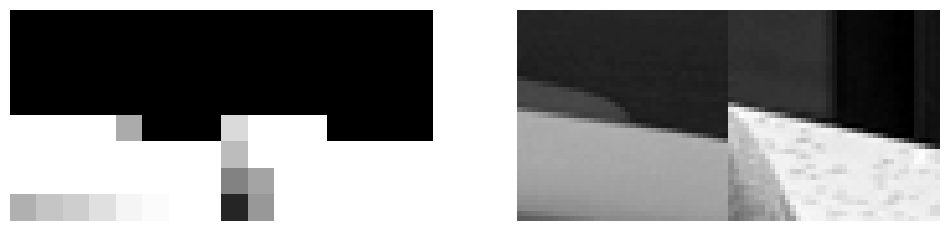

Feature pair 14


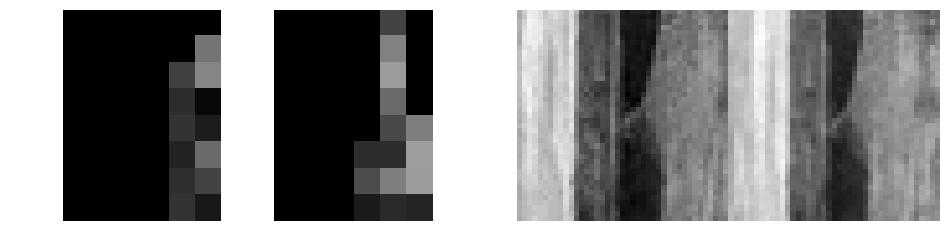

Feature pair 15


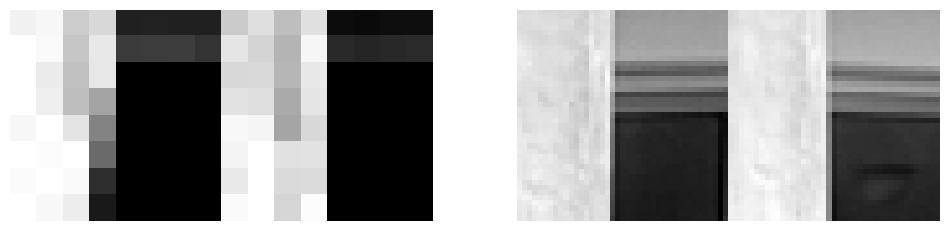

Feature pair 16


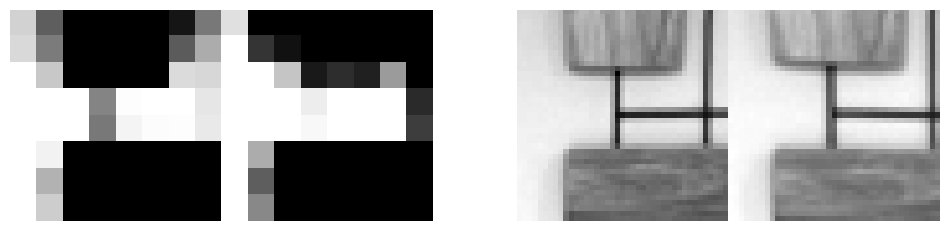

Feature pair 17


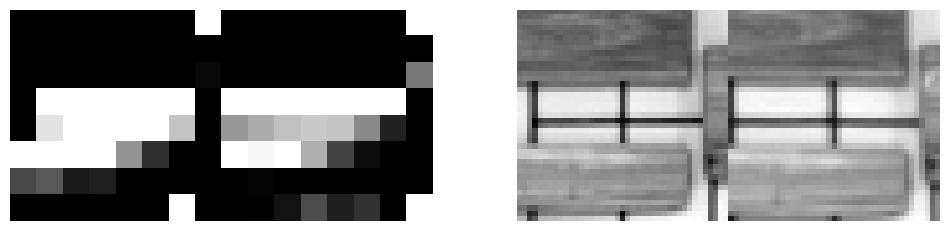

Feature pair 18


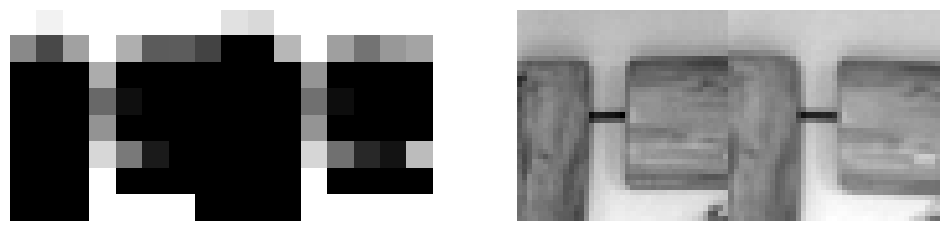

Feature pair 19


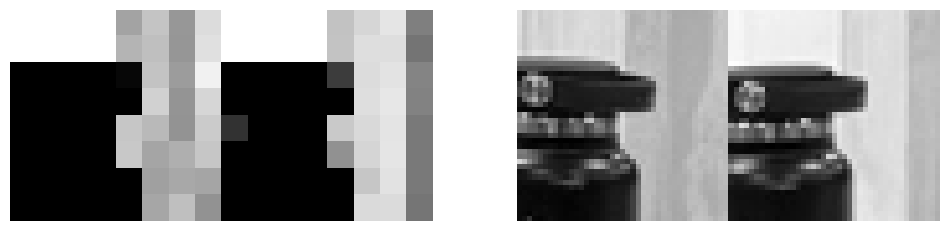

Feature pair 20


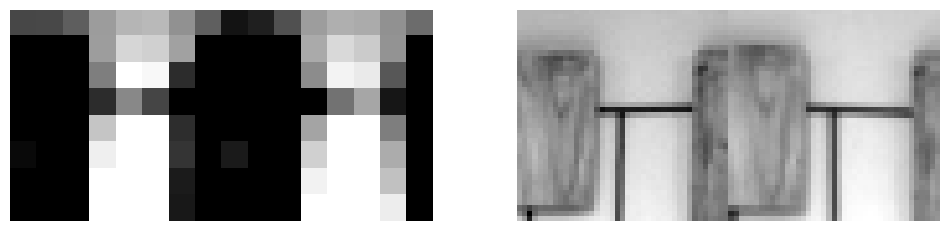

Feature pair 21


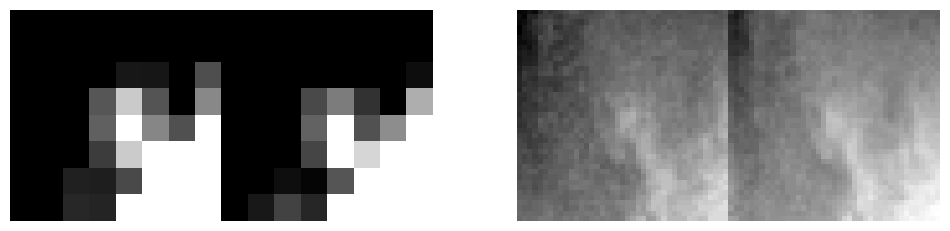

Feature pair 22


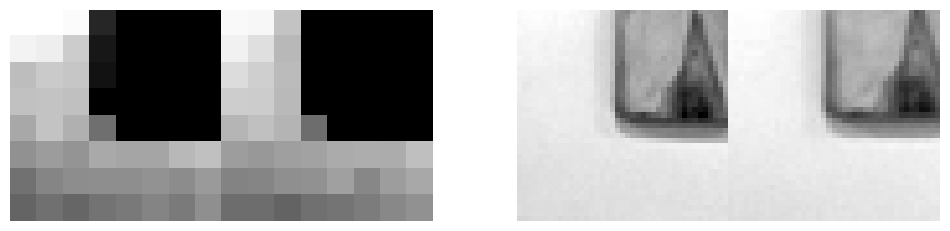

Feature pair 23


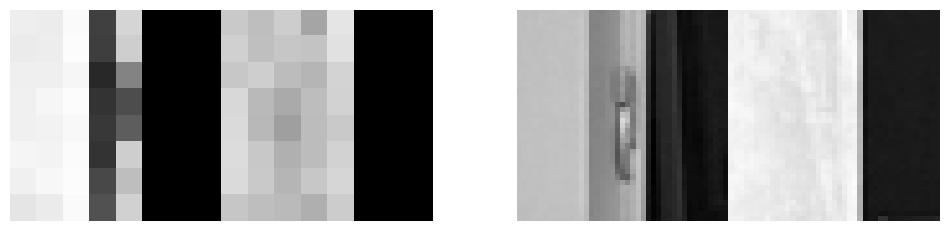

Feature pair 24


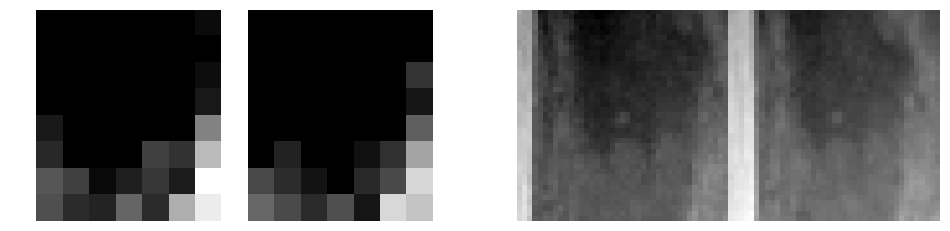

Feature pair 25


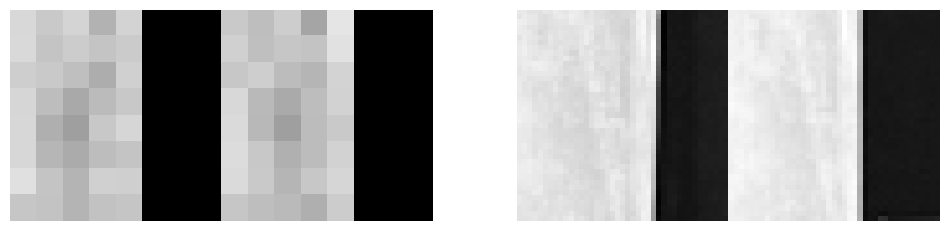

Feature pair 26


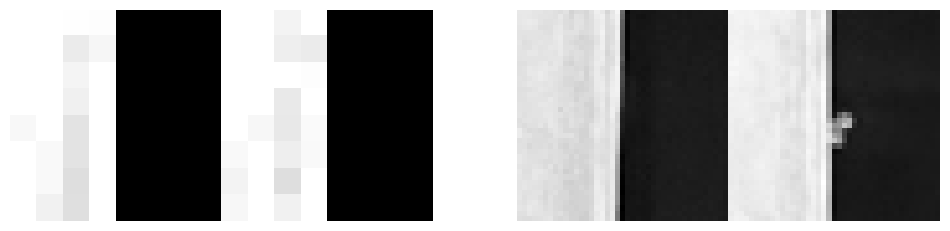

Feature pair 27


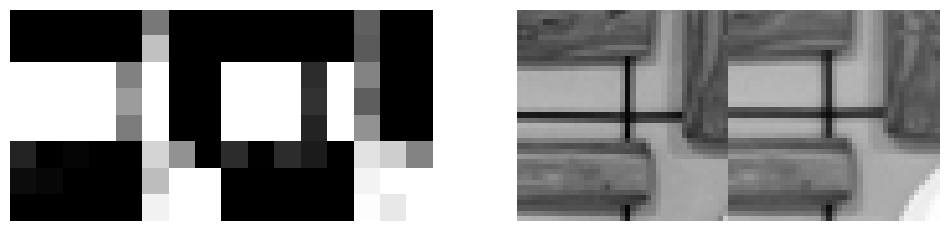

Feature pair 28


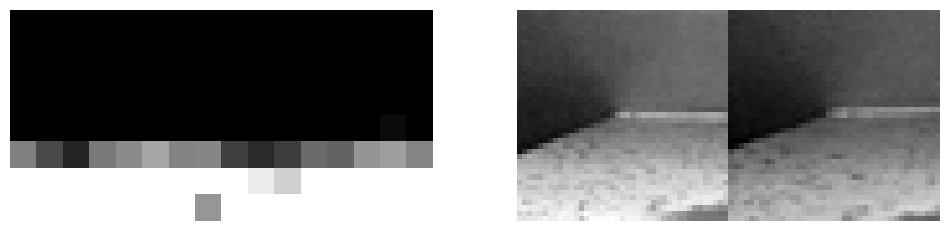

Feature pair 29


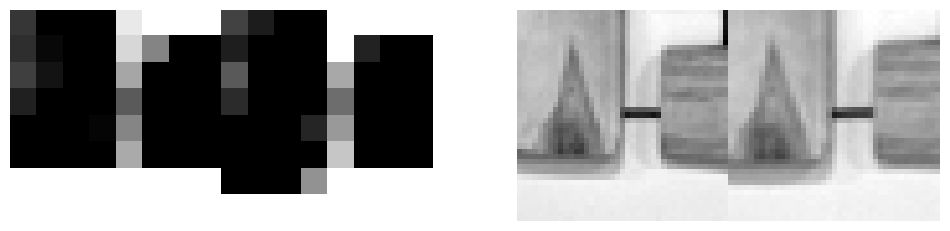

Feature pair 30


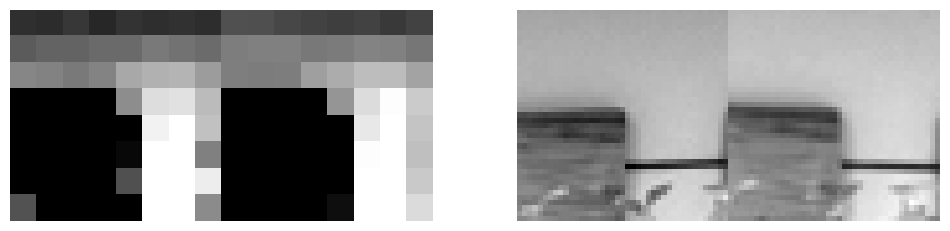

Feature pair 31


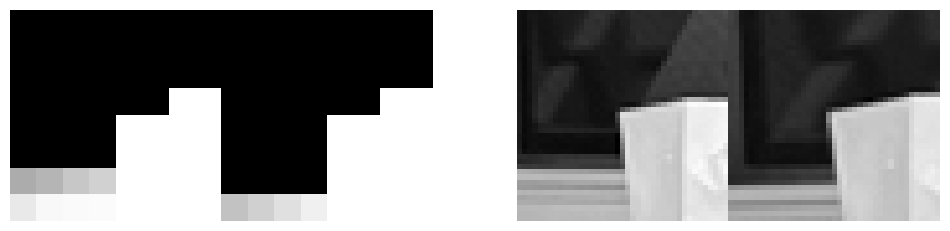

Feature pair 32


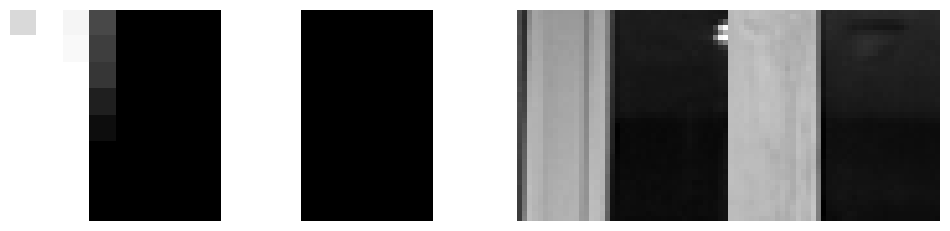

Feature pair 33


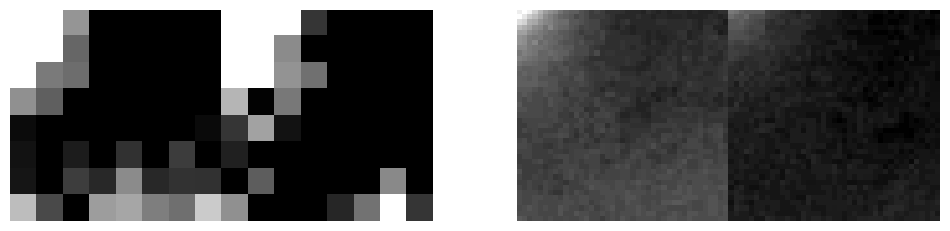

Feature pair 34


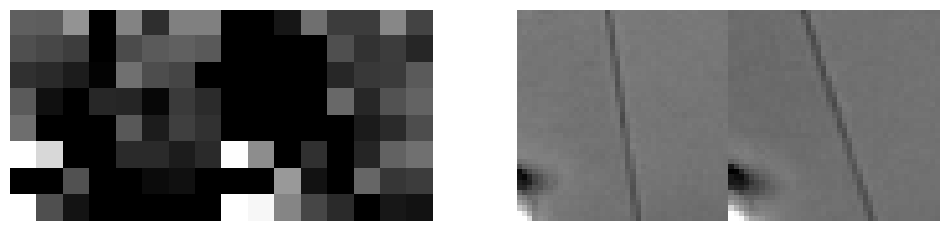

Feature pair 35


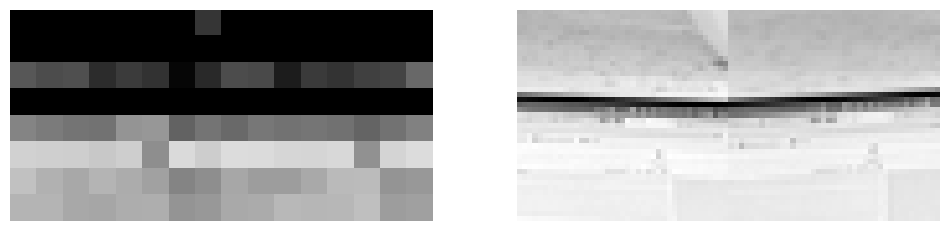

Feature pair 36


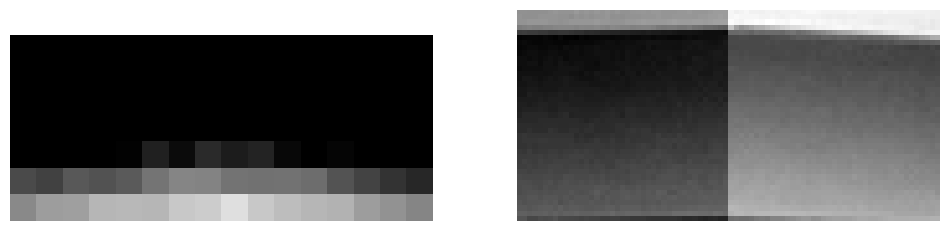

Feature pair 37


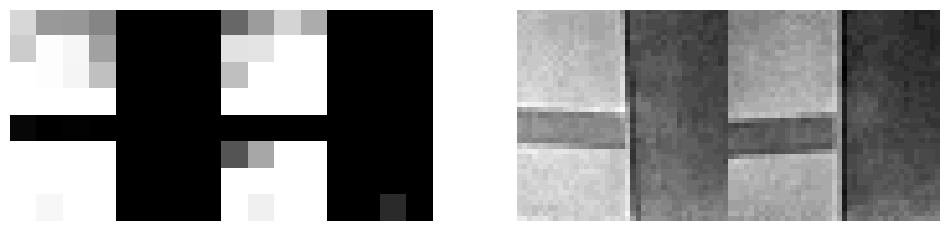

Feature pair 38


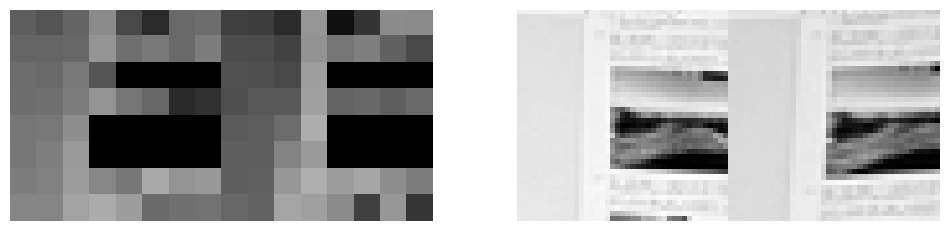

Feature pair 39


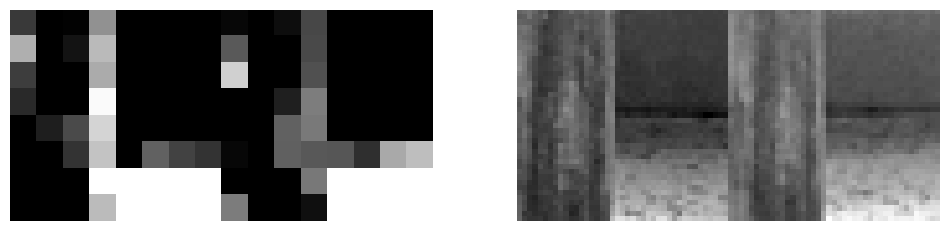

Feature pair 40


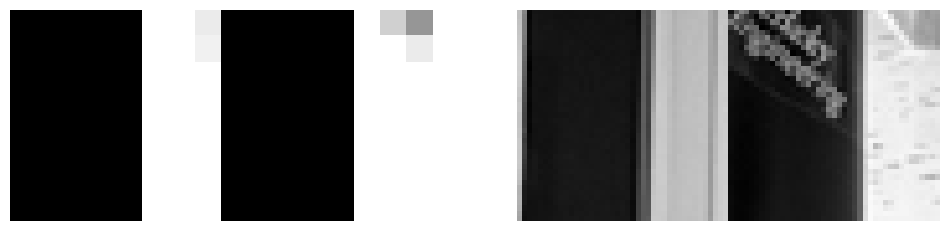

Feature pair 41


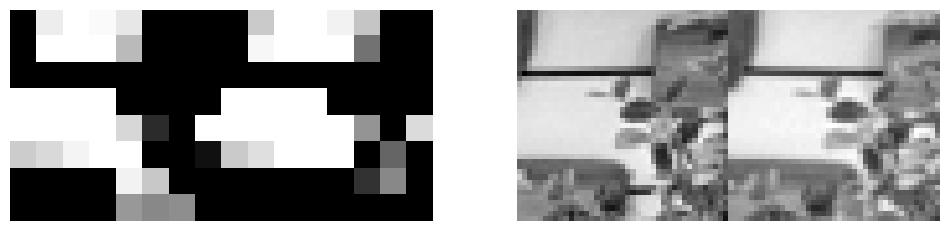

In [30]:
s, d = 8, 5
ksize_fd = 1 + s * d

im1fds = feature_descriptors(gray_im1, im1interest_points, s=s, d=d)
im2fds = feature_descriptors(gray_im2, im2interest_points, s=s, d=d)

im1patches = image_patches(gray_im1, im1interest_points, ksize=ksize_fd)
im2patches = image_patches(gray_im2, im2interest_points, ksize=ksize_fd)

for n, (i1, i2) in enumerate(pair_indices):
    print("Feature pair", n)
    
    desc = np.hstack([im1fds[i1], im2fds[i2]])
    desc_rgb = np.repeat(desc[..., None], 3, axis=2)
    desc_rgb = np.clip(desc_rgb, 0, 1)

    patch = np.hstack([im1patches[i1], im2patches[i2]])
    patch = np.clip(patch, 0, 1)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(desc_rgb); ax[0].axis("off")
    ax[1].imshow(patch, cmap="gray"); ax[1].axis("off")
    plt.show()

## Part 4: RANSAC for Robust Homography

In [31]:
def batch_computeH(batch_im1points, batch_im2points, mask=None):
    B, N, _ = batch_im1points.shape
    if mask is None:
        mask = np.ones((B, N), dtype=float)

    x, y = batch_im1points[..., 0], batch_im1points[..., 1]
    u, v = batch_im2points[..., 0], batch_im2points[..., 1]
    o = mask

    z = np.zeros_like(x)
    A1 = np.stack([x, y, o,  z, z, z, -u * x, -u * y, -u], axis=-1)
    A2 = np.stack([z, z, z,  x, y, o, -v * x, -v * y, -v], axis=-1)

    A = np.zeros((B, 2 * N, 9), dtype=float)
    A[:, 0::2, :] = A1
    A[:, 1::2, :] = A2

    row_w = np.zeros((B, 2 * N), dtype=float)
    row_w[:, 0::2] = o
    row_w[:, 1::2] = o
    A *= row_w[..., None]

    Hs = []
    for b in range(B):
        _, _, Vh = np.linalg.svd(A[b])
        h = Vh[-1]
        Hs.append((h.reshape(3, 3) / h[-1]))
    return np.stack(Hs, axis=0)


def batch_errorH(batch_H, im1points, im2points):
    N = im1points.shape[0]
    homo = np.concatenate([im1points.T, np.ones((1, N))], axis=0)
    proj = batch_H @ homo
    proj = (proj[:, :2] / proj[:, 2:])
    proj = np.transpose(proj, (0, 2, 1))
    return np.linalg.norm(proj - im2points[None, ...], axis=-1)


def ransacH(im1feature_points, im2feature_points, k=40000, t=10.0, d=0.5):
    N = im1feature_points.shape[0]
    best_H = None
    best_inliers = -1

    for _ in range(k):
        idx = np.random.choice(N, 4, replace=False)
        H = batch_computeH(im1feature_points[idx][None, ...], im2feature_points[idx][None, ...])[0]
        errs = batch_errorH(H[None, ...], im1feature_points, im2feature_points)[0]
        inliers = (errs < t)
        score = int(inliers.sum())

        if score > best_inliers:
            best_inliers = score
            best_H = batch_computeH(im1feature_points[None, ...], im2feature_points[None, ...], inliers[None, :].astype(float))[0]

    return best_H

In [32]:
def autoH(im1, im2):
    w = np.array([0.299, 0.587, 0.114], dtype=float)
    gray_im1 = (im1[..., :3] * w).sum(axis=-1)
    gray_im2 = (im2[..., :3] * w).sum(axis=-1)

    _, im1interest_points = harris_corners(gray_im1)
    _, im2interest_points = harris_corners(gray_im2)

    if im1interest_points.ndim == 2 and im1interest_points.shape[0] == 2:
        im1interest_points = im1interest_points.T
    if im2interest_points.ndim == 2 and im2interest_points.shape[0] == 2:
        im2interest_points = im2interest_points.T

    im1fds = feature_descriptors(gray_im1, im1interest_points)
    im2fds = feature_descriptors(gray_im2, im2interest_points)

    pairs = feature_match(im1fds, im2fds)

    im1feature_points = im1interest_points[pairs[:, 0]]
    im2feature_points = im2interest_points[pairs[:, 1]]

    return ransacH(im1feature_points, im2feature_points)

def auto_warp_blend(im1, im2, rectH=np.eye(3)):
    H12 = autoH(im1, im2)

    H1 = rectH @ H12
    H2 = rectH

    warped1, offset1 = warp(1, im1.astype(np.float32), H1)
    warped2, offset2 = warp(1, im2.astype(np.float32), H2)

    buf = buffer_images([warped1, warped2], [offset1, offset2]).astype(np.float32)
    return blend(buf)

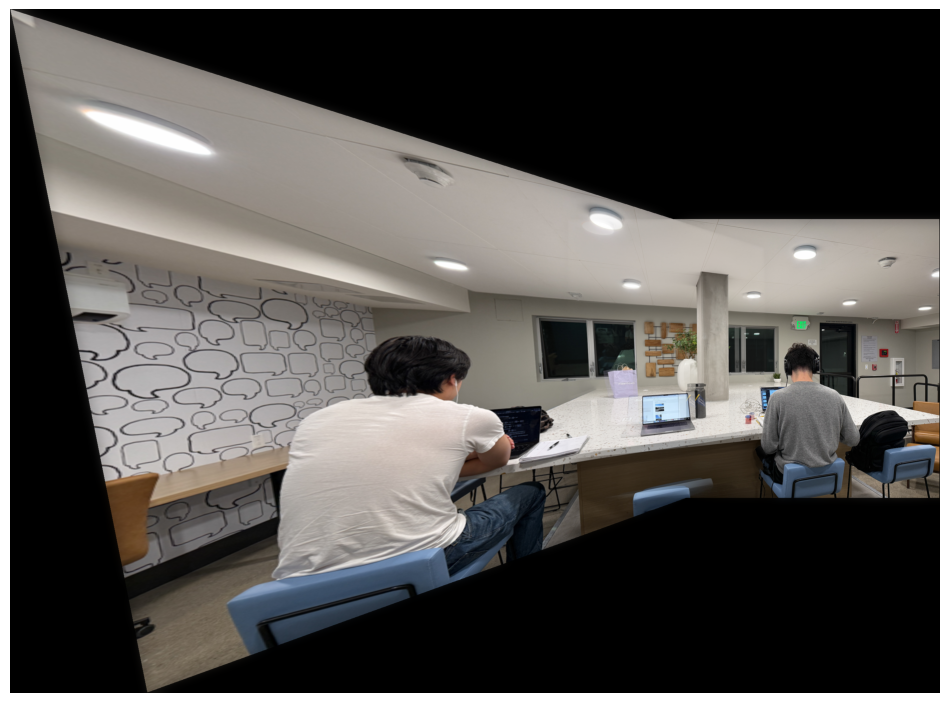

In [33]:
img1 = read_image("../../img/pano_5/1.jpg").astype(np.float32)
img2 = read_image("../../img/pano_5/2.jpg").astype(np.float32)

blended_img = auto_warp_blend(img1, img2)
plt.imshow(blended_img)
plt.axis("off")
plt.show()

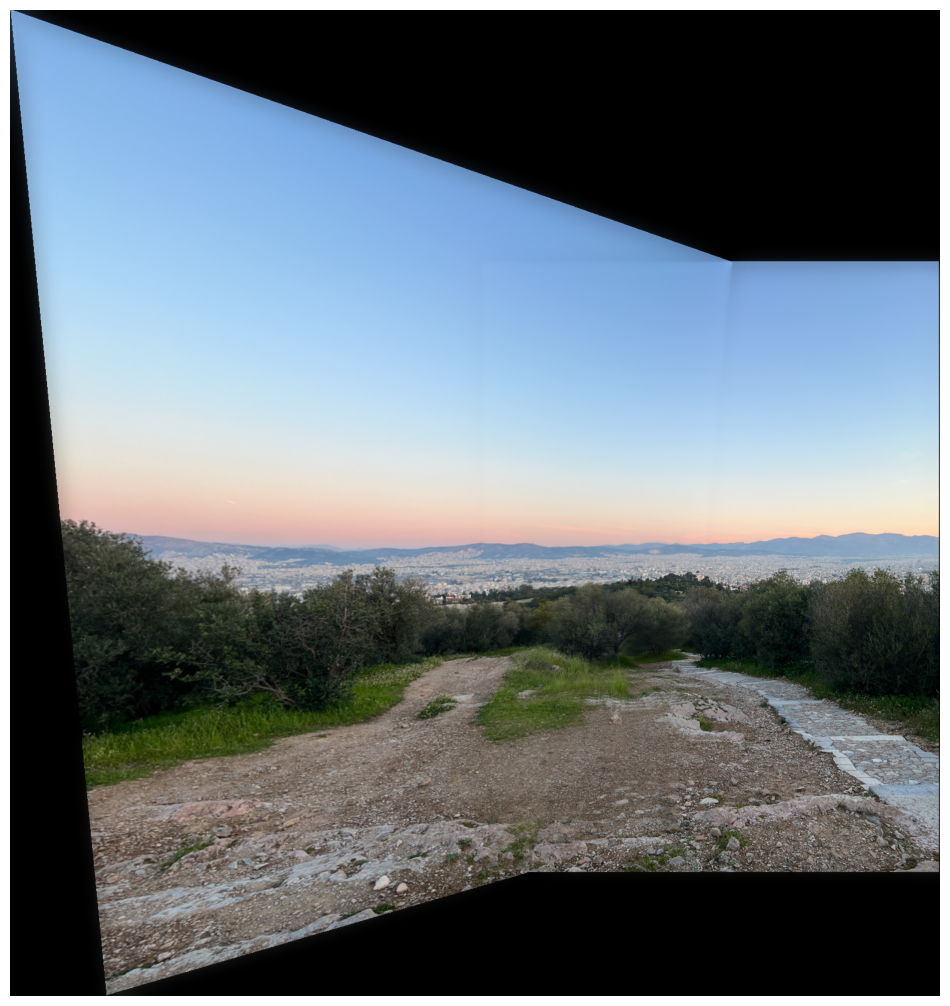

In [34]:
img1 = read_image("../../img/pano_3/2.jpg").astype(np.float32)
img2 = read_image("../../img/pano_3/3.jpg").astype(np.float32)

blended_img = auto_warp_blend(img1, img2)
plt.imshow(blended_img)
plt.axis("off")
plt.show()

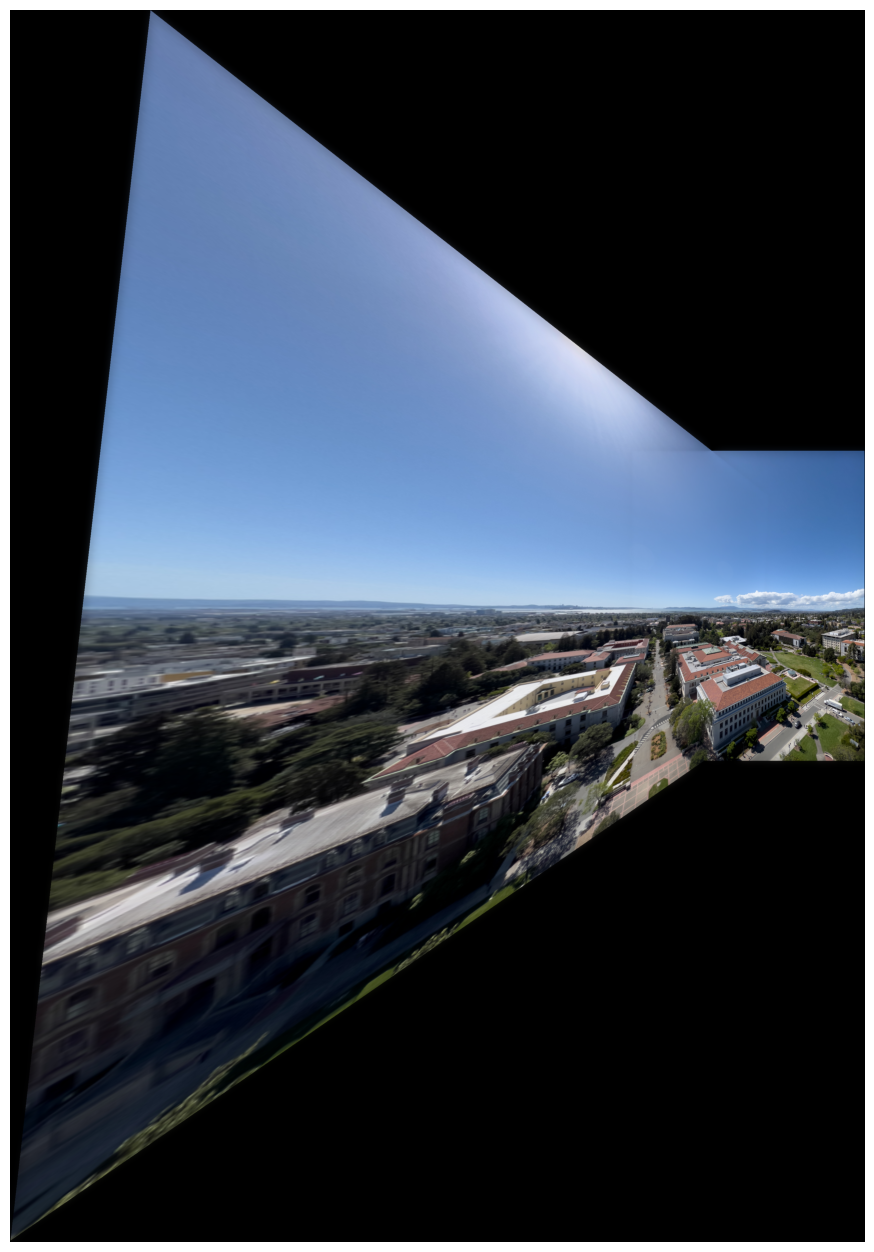

In [35]:
img1 = read_image("../../img/pano_4/5.jpg").astype(np.float32)
img2 = read_image("../../img/pano_4/6.jpg").astype(np.float32)

blended_img = auto_warp_blend(img1, img2)
plt.imshow(blended_img)
plt.axis("off")
plt.show()